### Chord detection using pitch class profiles and Essentia algorithms on The Beatles studio discography
##### Music Information Retrieval Course Project, Winter 2019
#### Written by Linda Bedrani

Using the Beatles discography dataset, this notebook will perform a chord detection analysis using low-level feature extraction from Essentia, and Essentia's ChordsDetection algorithm. The results will be evaluated by comparing to the chord annotations provided on the Isophonics website, which have been tried and true by the MIR community. These annotations are provided in the following format: 

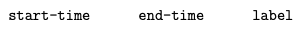

Chris Harte's doctoral dissertation on automatic extraction of harmony information using this same Beatles dataset described the following methodology for frame-based chord recognition: 

• Use of a tuning algorithm to generate a quantised chromagram.
• Generating the tonal centroid based on the 6D pitch class hypertorus.
• Development of the harmonic change detection function (HCDF)
from the tonal centroid.
• Use of peak picked HCDF for chord recognition segmentation.
• Improved peak picking of HCDF for better chord segmentation.

This is illustrated in the block diagram below, taken from this paper:

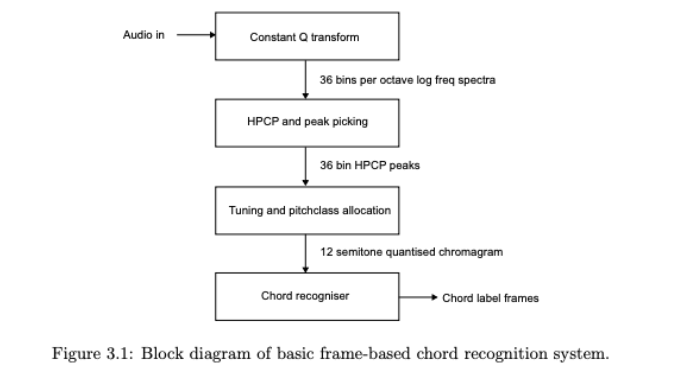

This is not the exact approach I will follow in this notebook. In order to compare the two chord-detecting algorithms from Essentia, I will follow a slightly different chord recognition system for each function.
This block diagram details the approach for ChordsDetection(). The implementation can be seen in the function FrameBasedChordDetection.

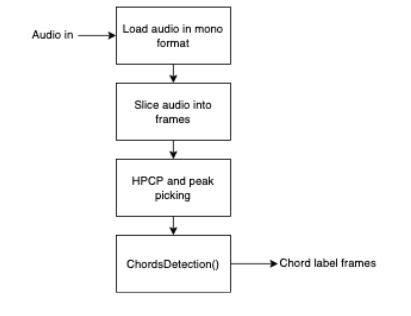

This next block diagram details the approach for ChordsDetectionBeats(). The implementation can be seen in the function BeatBasedChordDetection.

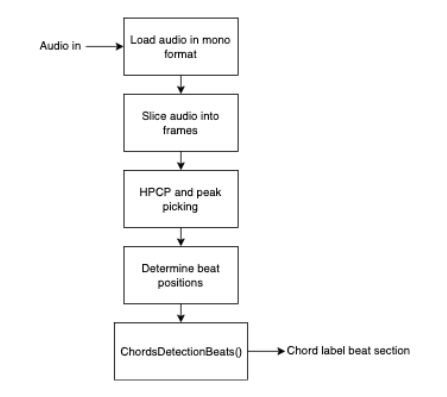

# Implementation
## Importing modules

In [158]:
# Import modules
import csv
import pandas as pd
import os
import glob
import sys, re
import numpy as np
import fileinput

# Import Essentia
import essentia.standard as ess
import essentia.streaming as esstr
import essentia

import mir_eval


# Import plotting modules
from pylab import plot, show, figure, imshow
import matplotlib.pyplot as plt

### Frame-based Chord Detection using essentia.streaming.ChordsDetection()

The following function will be called to perform the frame-based analysis and chord estimation.

This code is largely based off the function from
https://github.com/seffka/ACE2017/blob/master/essentia_chords.py

In [3]:
def FrameBasedChordDetection(filename, frameSize, tuningFreq=440, hopSize = 8192):
    
    loader = esstr.MonoLoader(filename = filename)
    framecutter = esstr.FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = esstr.Windowing(type="blackmanharris62")
    spectrum = esstr.Spectrum()
    spectralpeaks = esstr.SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    hpcp = esstr.HPCP(
        size=12,
        referenceFrequency = tuningFreq,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitSum')
    
    
    chords = esstr.ChordsDetection(
        hopSize = 16384,
        sampleRate = 44100,
        windowSize = 2.0)
        
    pool = essentia.Pool()
    
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectrum.spectrum >> (pool, 'spectrum.magnitude')
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')
 

    print("Processing audio file with frame-based chord detection...", filename)
    essentia.run(loader)
    
    
    # The default downmix for MonoLoader creates a mono mix of both stereo channels. 
    # This is important considering most Beatles songs that are mixed in sterea are mixed 
    #  with instruments hard-panned to the left or right. Losing one channel seriously 
    #  affect the results, if, for example, the rhythm guitar is lost in the downmix.
    
    audio = ess.MonoLoader(filename = filename)()
    endTime = len(audio) / 44100.0
    stamps = np.arange(0, endTime, float(hopSize/44100.0))
    stamps = np.array([round(stamp,2) for stamp in stamps])

    

    syms = list(pool['chords.chords'][:-1])
    strengths = list(pool['chords.strength'][:-1])
    

    chroma = pool['chroma.hpcp']
    chords = pool['chords.chords']
    chords_strength = pool['chords.strength']
        

    return stamps, chords


### Beat-based chord detection using essentia.standard.ChordsDetectionBeats()

The following function will be called to perform the frame-based analysis and chord estimation.

This code is largely based off the function from
https://github.com/seffka/ACE2017/blob/master/essentia_chords_beats.py

In [4]:
def BeatBasedChordDetection(filename) :

    chordHopSize = 4096
    frameSize = 8192
    tuningFreq = 440
    # initialize algorithms we will use
    loader = esstr.MonoLoader(filename=filename)
    framecutter = esstr.FrameCutter(hopSize=chordHopSize, frameSize=frameSize)
    windowing = esstr.Windowing(type="blackmanharris62")
    spectrum = esstr.Spectrum()
    spectralpeaks = esstr.SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = esstr.HPCP(size=12,
                referenceFrequency = tuningFreq,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)
    
    chords = ess.ChordsDetectionBeats()
        
    # use pool to store data
    pool = essentia.Pool()
    
    
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    print("Processing audio file with beat-based chord detection...", filename)
    essentia.run(loader)
    
    # The default downmix for MonoLoader creates a mono mix of both stereo channels. 
    # This is important considering most Beatles songs that are mixed in sterea are mixed 
    #  with instruments hard-panned to the left or right. Losing one channel seriously 
    #  affect the results, if, for example, the rhythm guitar is lost in the downmix.
    
    audio = ess.MonoLoader(filename = filename)()
    bt = ess.BeatTrackerMultiFeature()
    beats, _ = bt(audio)
    beats = beats[::4]

    chords = ess.ChordsDetectionBeats()
    syms, strengths = chords(pool['chroma.hpcp'], beats)
  
    return beats, syms


### Track evaluation function

This function calls the previous two functions that perform the analysis, and returns the results from both.

In [5]:
def evaluate_track(track):
    
    frame_stamps, frame_labels = FrameBasedChordDetection(track, frameSize=8192)
    beat_stamps, beat_labels = BeatBasedChordDetection(track)
    
    return frame_stamps, frame_labels, beat_stamps, beat_labels

### mir_eval evaluation function

This function will take in two lab files and compare them using the mir_eval module. It expects two .lab files as input, and will return an object with relevant parameters for evaluation.

In [29]:
def evaluateChords(estimate_file, reference_file):
    
    (ref_intervals, ref_labels) = mir_eval.io.load_labeled_intervals(reference_file)
    (est_intervals, est_labels) = mir_eval.io.load_labeled_intervals(estimate_file, delimiter =' ')
    est_intervals, est_labels = mir_eval.util.adjust_intervals(est_intervals, est_labels, ref_intervals.min(), ref_intervals.max(), mir_eval.chord.NO_CHORD, mir_eval.chord.NO_CHORD)
    (intervals, ref_labels, est_labels) = mir_eval.util.merge_labeled_intervals(ref_intervals, ref_labels, est_intervals, est_labels)
    durations = mir_eval.util.intervals_to_durations(intervals)
    comparisons = mir_eval.chord.mirex(ref_labels, est_labels)
    score = mir_eval.chord.weighted_accuracy(comparisons, durations)
    
    return score

### Main function - evaluating the dataset

In the implementation of the main function, where all tracks will be evaluated and the frame-based and beat-based analysis functions will be called, the idea was to do a recursive run through of the audio files and creation of subsequent lab files containing the estimated chord annotations. However, iterating through the audio files recursively somehow always led to errors with mp3 files not working with the Essentia MonoLoader function. When the tracks were input into this function individually, there were no issues. There was no solution I could track down online, for this, and I assume it has something to do with the dataset that I had to create for this project (due to copyright distribution laws on The Beatles discography. The bug persisted by using the os.walk() and the glob.glob() methods for recursive parsing of the directory.

Due to lack of time, I could not investigate this bug further, since the MP3 files all worked properly and were correctly called, etc. Therefore, I proceeded to hard-code each track name and run the following cells individually for each track...
...in the end this resulted in .lab files being created for each track, one for both the frame-based and the beat-based chord estimation analyses. 

The following cell shows this hard-coded implementation for the last album, Let It Be, where each track was commented/uncommented out as needed. 

The resulting .lab files were written in the format described earlier, following the MIREX convention (start_time end_time chord_label).

In [38]:
#Initialize parameters 
audio_database = './audio/'

# Set album name
album = '12_Let_It_Be/'

# Set track name
#track = "01_-_Two_of_Us"
#track = "02_-_Dig_a_Pony"
#track = "03_-_Across_the_Universe"
#track = "04_-_I_Me_Mine"
#track = "05_-_Dig_It"
#track = "06_-_Let_It_Be"
#track = "07_-_Maggie_Mae"
#track = "08_-_Ive_Got_A_Feeling"
#track = "09_-_One_After_909"
#track = "10_-_The_Long_and_Winding_Road"
#track = "11_-_For_You_Blue"
track = "12_-_Get_Back"

frame_dict = dict()
beat_dict = dict()

frame_durations = []
beat_durations = []


frame_stamps, frame_labels, beat_stamps, beat_labels = evaluate_track(audio_database+album+track+'.mp3')

# Compute durations for frame-based analysis
for i in range(len(frame_stamps)-1):
    frame_durations.append(round(frame_stamps[i+1]-frame_stamps[i], 4))
    
# Compute durations for beat-based analysis
for i in range(len(beat_stamps)-1):
    beat_durations.append(round(beat_stamps[i+1]-beat_stamps[i], 4))
    
# Set the dictionary key as the track name
track_id = track.split('.m')[0]

# Set the dictionary values as the start times, end times, and chord labels
frame_dict[track_id] = frame_stamps[0:(len(frame_stamps)-1)], frame_stamps[1:len(frame_stamps)], frame_labels
beat_dict[track_id] = beat_stamps[0:(len(beat_stamps)-1)], beat_stamps[1:len(beat_stamps)], beat_labels


#Rename to accepted chord syntax
np.core.defchararray.replace(frame_dict[track_id][2],'m', ':min')




# Write a lab file with the estimated annotations from frame-based analysis
with open('./frame_labs/'+album+track_id+'_frame.lab', 'w') as content_file:
    for key, val in frame_dict.items():
        col = zip(*val)
        for v in col: 
            for i in v:
                content_file.write(str(i)+ ' ')
            content_file.write('\n')
            
print('Frame lab file was written')
            
# Write a lab file with the estimated annotations from beat-based analysis
with open('./beat_labs/'+album+track_id+'_beat.lab', 'w') as content_file:
    for key, val in beat_dict.items():
        col = zip(*val)
        for v in col: 
            for i in v:
                content_file.write(str(i)+ ' ')
            content_file.write('\n')
            
print('Beat lab file was written')

Processing audio file with frame-based chord detection... ./audio/12_Let_It_Be/12_-_Get_Back.mp3
Processing audio file with beat-based chord detection... ./audio/12_Let_It_Be/12_-_Get_Back.mp3
Frame lab file was written
Beat lab file was written


### Re-write chord labels to match reference syntax
In the annotated lab files, minor chords are denoted with a colon and 'min. For instance, an A minor chord is denoted as 'A:min'. This syntax is described in section 4.3 of Harte's doctoral dissertation (see references)

The outputs from ChordsDetection and ChordsDetectionBeats algorithms in Essentia would write an A minor chord as 'Am'. In order to be able to compare the annotated chord labels with the estimated chords from Essentia, the estimated labels must be converted to the same syntax as the ground-truth annotations.

The following lines of code are to replace the 'm' with ':min' in the estimated chord annotations from the Essentia algorithms. 

In [48]:
import fnmatch 

for path, dirs, files in os.walk(os.path.abspath('./frame_labs/')):
        for filename in fnmatch.filter(files, "*.lab"):
            filepath = os.path.join(path, filename)
            with open(filepath) as f:
                s = f.read()
            s = s.replace('m', ':min')
            with open(filepath, "w") as f:
                f.write(s)
                
for path, dirs, files in os.walk(os.path.abspath('./frame_labs/')):
        for filename in fnmatch.filter(files, "*.lab"):
            filepath = os.path.join(path, filename)
            with open(filepath) as f:
                s = f.read()
            s = s.replace('m ', ':min')
            with open(filepath, "w") as f:
                f.write(s)

### Evaluate the results and compare with reference files
Now that we have estimation .lab files for each track, written in the same format as the reference .lab files, we can proceed to the evaluation of the estimated chords using mir_eval. The mir_eval will compare the estimated chords to the reference chords and assign a score using the weighted_accuracy function. The score ranges from 0 to 1, 1 being a perfect score. 

Since this is the same task as 2017 MIREX (Audio Chord Estimation), I decided to use the mirex function in the chord subset of the mir_eval module for evaluation.

In [43]:
# Initialize arrays that will hold the evaluated scores per track for each album
frame_results_01 = []
frame_results_02 = []
frame_results_03 = []
frame_results_04 = []
frame_results_05 = []
frame_results_06 = []
frame_results_07 = []
frame_results_08 = []
frame_results_09 = []
frame_results_10 = []
frame_results_11 = []
frame_results_12 = []
frame_results_13 = []

# Initialize arrays that will hold the evaluated scores per track for each album
beat_results_01 = []
beat_results_02 = []
beat_results_03 = []
beat_results_04 = []
beat_results_05 = []
beat_results_06 = []
beat_results_07 = []
beat_results_08 = []
beat_results_09 = []
beat_results_10 = []
beat_results_11 = []
beat_results_12 = []
beat_results_13 = []

The following will evaluate the results for the frame-based .lab files.

In [125]:
ref_path = './labs/11_Abbey_Road/'
frame_path = './frame_labs/11_Abbey_Road/'

for path, dirs, files in os.walk(os.path.abspath('./audio/11_Abbey_Road/')):
    for file in files:
        if '.mp3' not in file:
            continue
        track_name = os.path.basename(file)
        lab_name = os.path.splitext(track_name)[0] 
        ref_lab = ref_path + lab_name + '.lab'
        frame_lab = frame_path + lab_name + '_frame.lab'
        score = evaluateChords(frame_lab, ref_lab)
        frame_results_12.append(score)



The following will evaluate the results for the beat-based .lab files.

In [93]:
ref_path = './labs/11_Abbey_Road/'
beat_path = './beat_labs/01_Please_Please_Me/'

for path, dirs, files in os.walk(os.path.abspath('./audio/01_Please_Please_Me/')):
    for file in files:
        if '.mp3' not in file:
            continue
        track_name = os.path.basename(file)
        lab_name = os.path.splitext(track_name)[0] 
        ref_lab = ref_path + lab_name + '.lab'
        beat_lab = beat_path + lab_name + '_beat.lab'
        score = evaluateChords(beat_lab, ref_lab)
        beat_results_01.append(score)


### Plotting the results

We can create plots to show the mir_eval scores for each track, and potentially deduce trends from the results.

For this analysis, I decided to approach the tracks by album. The Beatles discography is quite musically diverse, and the musical stylings vary greatly between albums (compare, for example, Sgt. Pepper to A Hard Day's Night). I thought it would be interesting to see if the algorithms performed better for certain albums than others. It could also be interesting to see if one algorithm performs better for the later, more musically eclectic Beatles albums versus the other. 

#### Plots for each album

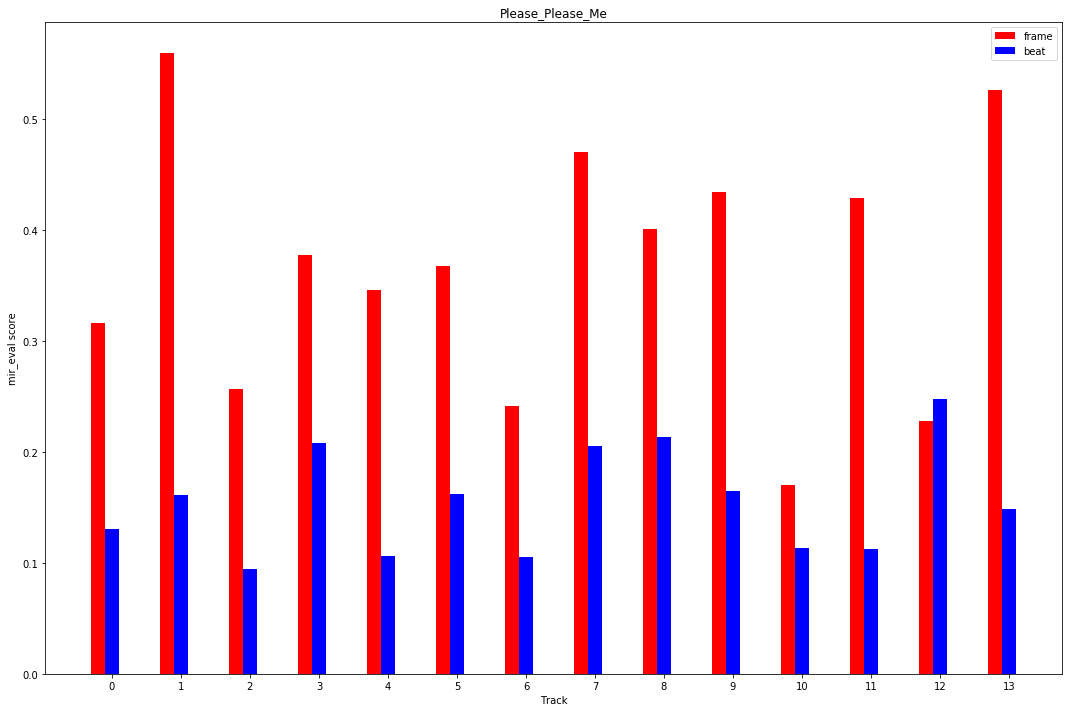

In [182]:
# Set parameters for plot
width=0.2
album = 'Please_Please_Me'
length=len(frame_results_01)
index = np.arange(length)

fig, ax = plt.subplots(figsize = (15,10))
ax.set_xlabel('Track')
ax.set_ylabel('mir_eval score')
ax.set_title(album)
ax.bar(index, frame_results_01, width, color="red", label='frame')
ax.bar(index+width, beat_results_01, width, color="blue", label='beat')
ax.set_xticks(index+width)
ax.set_xticklabels(index)
ax.legend()

fig.tight_layout()
plt.savefig('./plots/'+album+'.png', format = 'png')
plt.show()

The results from the comparison bar graphs show that the ChordsDetection algorithm vastly outperforms ChordDetectionBeats on all Beatles albums. 

This is almost unanimous; in fact, the only track on which ChordsDetectionBeats has a better score is Helter Skelter, off of the second disc of the White album. This is a curious result, which could be attributed to the fact that Helter Skelter is has very prominent beats, which resulted in a better segmentation coming from the beat-based analysis. The guitar on this track is heavily distorted, which may have affected the chord detection in the frame-based analysis. 

The figure below shows the bar chart obtained from 10CD2_The_Beatles (The White Album), with Helter Skelter at Track 7. 

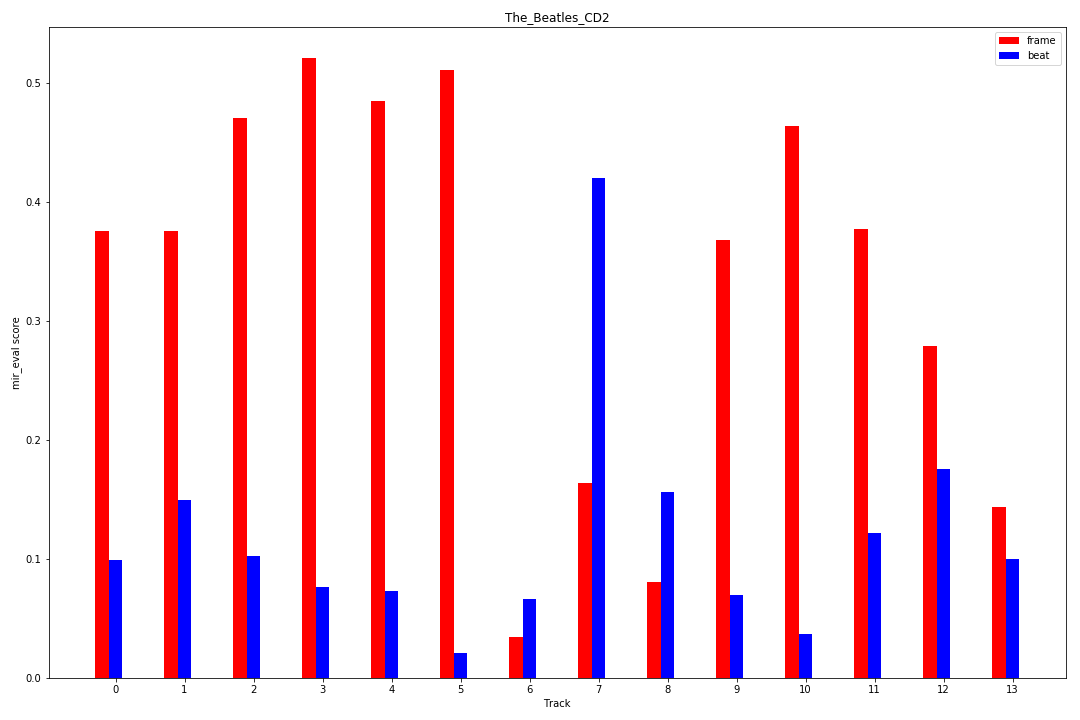

To show the superior performance of the frame-based analysis, the following figure shows the results for the album Rubber Soul. The scores of the frame-based analysis are almost always more than double those of the beat-based analysis. 

The plots for the rest of the albums can be found in the "plots" folder in this directory.

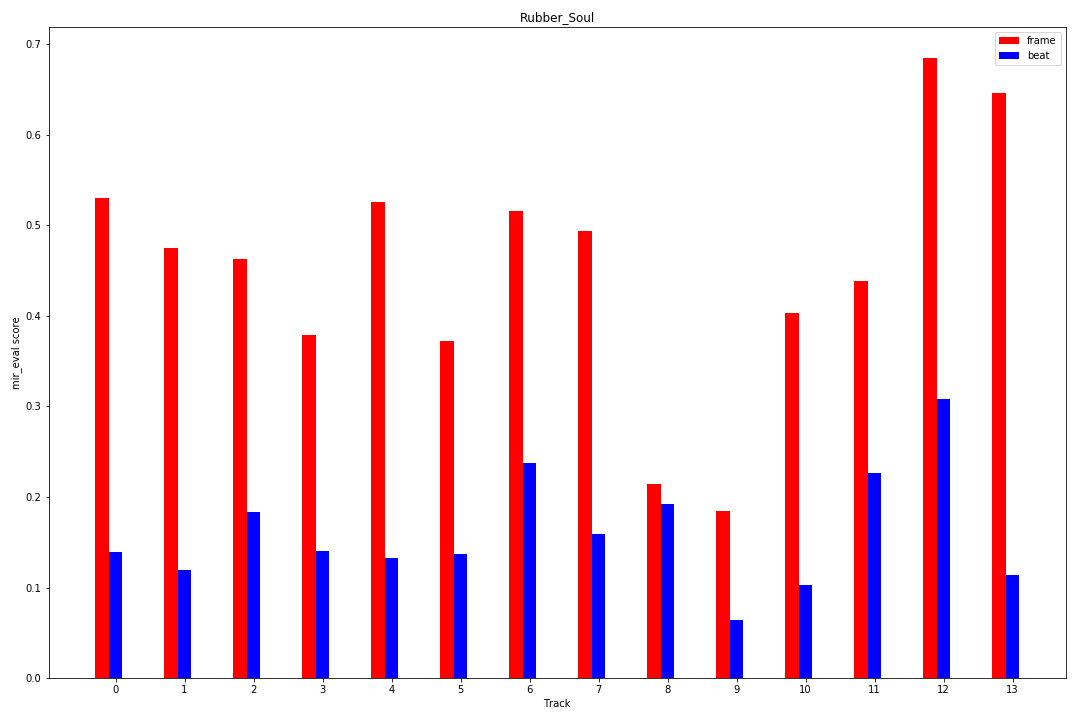

### Overall Average Plots

Now that we have created bar charts that show the results within each album, we can combine these results and plot one collective graph that shows all the albums together. Instead of showing the results from each track, we will compute the average score across each album, and compare the average scores of all albums on one plot. 

In [197]:
# Function to compute the average of an array. 
#We will pass each array containing the scores from the frame-/beat- based analyses.

def average(a, n): 
    sum = 0
    for i in range(n): 
        sum += a[i] 
      
    return sum/n; 



all_frame_results = [frame_results_01, 
                     frame_results_02, 
                     frame_results_03, 
                     frame_results_04, 
                     frame_results_05,
                     frame_results_06, 
                     frame_results_07,
                     frame_results_08, 
                     frame_results_09,
                     frame_results_10, 
                     frame_results_11,
                     frame_results_12, 
                     frame_results_13]

frame_total = []

for i in all_frame_results:
    avg = average(i, len(i))
    frame_total.append(avg)



all_beat_results = [beat_results_01, 
                    beat_results_02,
                    beat_results_03, 
                    beat_results_04,
                    beat_results_05, 
                    beat_results_06,
                    beat_results_07, 
                    beat_results_08,
                    beat_results_09, 
                    beat_results_10,
                    beat_results_11, 
                    beat_results_12,
                    beat_results_13]
                     

beat_total = []

for i in all_beat_results:
    avg = average(i, len(i))
    beat_total.append(avg)
    
print('Average scores for all albums in frame-based analysis:')
print(frame_total)
print('Average scores for all albums in beat-based analysis:')
print(beat_total)

Average scores for all albums in frame-based analysis:
[0.36619322673314836, 0.45373966337783916, 0.49590759301548309, 0.44628096726654276, 0.47168660210771696, 0.4519062651690528, 0.43600705246049998, 0.17821362595781423, 0.50279889439030667, 0.49050173962687049, 0.33237023673008759, 0.43746368258947232, 0.45687783252260239]
Average scores for all albums in beat-based analysis:
[0.15525761896680756, 0.14661759514161593, 0.13318526218377194, 0.18973833038747243, 0.15425934529575019, 0.1611093659533897, 0.14936664709847539, 0.11222659080195448, 0.16548358040715933, 0.12711200228302189, 0.11941821221515182, 0.1117914239097505, 0.16491138611238135]


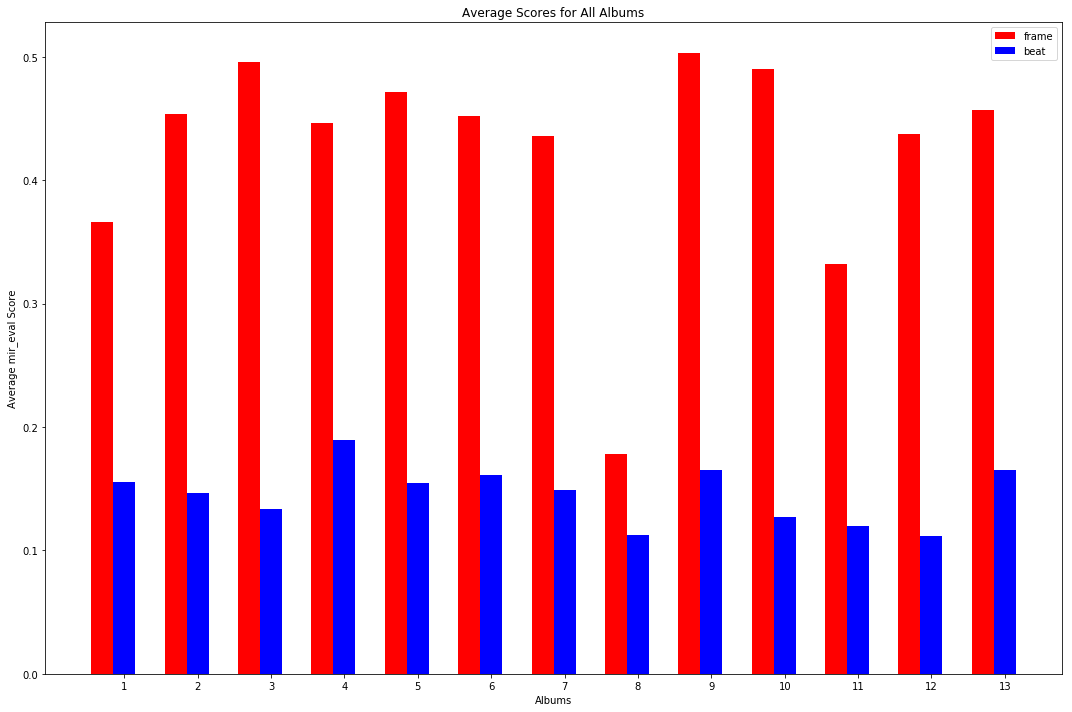

In [190]:
# Set parameters for plot
width=0.3
length=len(frame_total)
index = np.arange(length)

#Set album numbers to start at 1
for i in index:
    index[i]=index[i]+1

fig, ax = plt.subplots(figsize = (15,10))
ax.set_xlabel('Albums')
ax.set_ylabel('Average mir_eval Score')
ax.set_title('Average Scores for All Albums')
ax.bar(index, frame_total, width, color="red", label='frame')
ax.bar(index+width, beat_total, width, color="blue", label='beat')
ax.set_xticks(index+width)
ax.set_xticklabels(index)
ax.legend()

fig.tight_layout()
plt.savefig('./plots/'+'Average_Album_Scores.png', format = 'png')
plt.show()

This plot clearly shows the ubiquity of the frame-based algorithm's lead over the beat-based algorithm. It is interesting to see that the frame-based chord detection scored exceptionally low for the Sgt. Pepper Lonely Hearts Club Band album. This album is a standout in terms of musical genre within the Beatles discography, so this outliar could be due to a fallback in the frame-based performance for these songs. However, the songs on this album are all clearly tonal, with little distortion, so this score cannot be directly explained by a musical derivative. 

It is also important to note that while the frame-based algorithm scored higher than the beat-based algorithm, its average score still did not surpass 0.5. On a scale of 0 to 1, this is not a great score. These are complex and polyphonic recordings, and by looking through a sample lab file showing the frame-based chord annotations, it shows that the algorithm changes estimated chords quite dramatically from frame to frame. 

It may improve the results to single out the instrument producing the main chords, through chroma features. This would be hard to do in terms of contextualizing the results for different types of music. For instance, with The Beatles, the chords are usually played either with electric rhythm guitar or piano. The spectral/chroma parameters should be tweaked contextually for different datasets. 

In [199]:
# Overall average across ALL albums
frame_average = average(frame_total, len(frame_total))
beat_average = average(beat_total, len(beat_total))
print('The average score across all albums for the frame-based analysis was:')
print(frame_average)
print('The average score across all albums for the beat-based analysis was:')
print(beat_average)

The average score across all albums for the frame-based analysis was:
0.424611337073
The average score across all albums for the beat-based analysis was:
0.145421335443


The two Essentia chord-detecting algorithms used for this analysis have some setbacks to note that may explain at least partway why they scored low. The algorithms are limited in the chords that they are able to detect. Both only output major and minor triads, which limits the range of chords output (i.e.: The Beatles discography often uses variations on major/minor triads). 

Under the Essentia algorithm reference, both algorithms are listed as having 'experimental' quality (e.g.: prone to errors), so the expected results were not high scores after mir_eval evaluation. 

In general, a probable reason for misidentified tones is mixing up chords that share similar tones or mistaking chords for others based on prominent notes. This is very probable, given that these recordings are polyphonics, and often use many different instruments and different melodic lines for bass, vocals, etc.

Table 5.1 in Harte's dissertation illustrates a set of chords and maps the number of tones that they share. This table can be used for guidance to potentially trace tendencies in the Essentia algorithms to specific mistakes in chord classification.

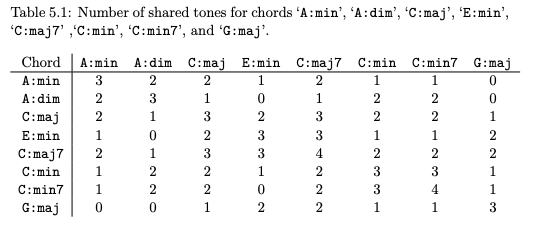

### References
##### Code snippets:

https://github.com/seffka/ACE2017
- essentia_chord_utils
- essentia_chords
- essentia_chord_beats

##### MIR Notebooks:

Lecture4_step2_ChordDetectionDemo

##### mir_eval:

Colin Raffel, Brian McFee, Eric J. Humphrey, Justin Salamon, Oriol Nieto, Dawen Liang, and Daniel P. W. Ellis, "mir_eval: A Transparent Implementation of Common MIR Metrics", Proceedings of the 15th International Conference on Music Information Retrieval, 2014.

https://craffel.github.io/mir_eval/

##### Essentia chord-detection algorithms

https://essentia.upf.edu/documentation/reference/streaming_ChordsDetection.html
https://essentia.upf.edu/documentation/reference/std_ChordsDetectionBeats.html

##### ACE references:

- 2017 MIREX-09 https://www.music-ir.org/mirex/wiki/2017:Audio_Chord_Estimation 
- Harte, C. (2010). Towards automatic extraction of harmony information from music signals (Doctoral dissertation). 

##### Datasets:

Beatles audio dataset: Provided by author, not included due to copyright and distribution laws. The dataset consists of 12 studio albums by the Beatles: Please Please Me, With The Beatles, A Hard Day's Night, Beatles For Sale, Help!, Rubber Soul, Revolver, Sgt. Pepper's Lonely Hearts Club Band, Magical Mystery Tour, The Beatles (CD1 and 2), Abbey Road, and Let It Be.

Beatles chord annotation datasets: http://www.isophonics.net/content/reference-annotations-beatles
